In [118]:
pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Exploratory data analysis - UK & France Day-Ahead Power Prices

In this notebook we:
1. Explore historical hourly prices for UKL and France (Jan-July 2025)
2. Construct the spread series (UK & FR) in EUR/MWh
3. Analyse correlation, volatility, and descriptive statistics.
4. Produce visualisations to understand price behaviour.

In [119]:
import pandas as pd  
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath("/Users/Lyndon.Odia/Desktop/lo-devx/power-spread-option-pricing-main"))
from config import raw_data_dir, processed_data_dir, API_KEY, FR_DOMAIN, START_DATE, END_DATE, FX_GBP_EUR
 

In [120]:
# Settings for plots
plt.rcParams["figure.figsize"] = (12, 6)

In [121]:
# Load merged hourly dataset - 
data_path = os.path.join(processed_data_dir, "UK_FR_day_ahead_hourly_010125-31072025.csv")
df = pd.read_csv(data_path, parse_dates=["datetime"])

In [122]:
# Ensure sorted and clean
df = df.sort_values("datetime").reset_index(drop=True)

In [123]:
#Convert GBP to EUR using the exchange rate from config (1.17)
FX_GBP_EUR  
if "UK_price_eur" not in df.columns:
   df["UK_price_eur"] = df["UK_price"] * FX_GBP_EUR
   
# Create spread (EUR/MWh) - difference between the UK and France prices
df["spread_eur"] = df["UK_price_eur"] - df["FR_price"]
df.head(5)

,datetime,FR_price,UK_price,UK_price_eur,spread_eur
0,2025-01-01 01:00:00,16.66,70.001,81.90117,65.24117
1,2025-01-01 02:00:00,13.10,74.074,86.66658,73.56658
2,2025-01-01 03:00:00,5.90,78.937,92.35629,86.45629
3,2025-01-01 04:00:00,9.27,62.961,73.66437,64.39437
4,2025-01-01 05:00:00,10.04,61.395,71.83215,61.79215


In [124]:
#save to processed path
output_path_2 = os.path.join(processed_data_dir, "UK_FR_day_ahead_hourly_merged_spread.csv")
df.to_csv(output_path_2, index=False)
print(f"Merged hourly dataset saved to {output_path_2}")

Merged hourly dataset saved to /Users/Lyndon.Odia/Desktop/lo-devx/power-spread-option-pricing-main/data/processed/UK_FR_day_ahead_hourly_merged_spread.csv


In [125]:
#data health check
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4229 entries, 0 to 4228
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      4229 non-null   datetime64[ns]
 1   FR_price      4229 non-null   float64       
 2   UK_price      4229 non-null   float64       
 3   UK_price_eur  4229 non-null   float64       
 4   spread_eur    4229 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 165.3 KB
None
                            datetime     FR_price     UK_price  UK_price_eur  \
count                           4229  4229.000000  4229.000000   4229.000000   
mean   2025-04-11 01:51:06.256798208    77.876938    69.862044     81.738592   
min              2025-01-01 01:00:00     0.020000    35.217000     41.203890   
25%              2025-02-15 04:00:00    36.270000    62.887000     73.577790   
50%              2025-04-03 21:00:00    77.450000    70.135000     82.057950  

In [126]:
# Check date range and hourly continuity
print("Start:", df["datetime"].min(), "End:", df["datetime"].max())
expected_hours = pd.date_range(df["datetime"].min(), df["datetime"].max(), freq="h")
missing = expected_hours.difference(df["datetime"])
print("Missing hours:", len(missing))

Start: 2025-01-01 01:00:00 End: 2025-07-31 23:00:00
Missing hours: 858


# 858 missing hours explanation
- After checking the missing hours distribution, conclusion
1. ENTSO-E reporting gaps for FR market
2. This may be due to partial hourly outages in ENTSO-E API.
3. There approach is good to keep merge as is (inner join) so that I'm working with timestamps where both UK and FR have values.


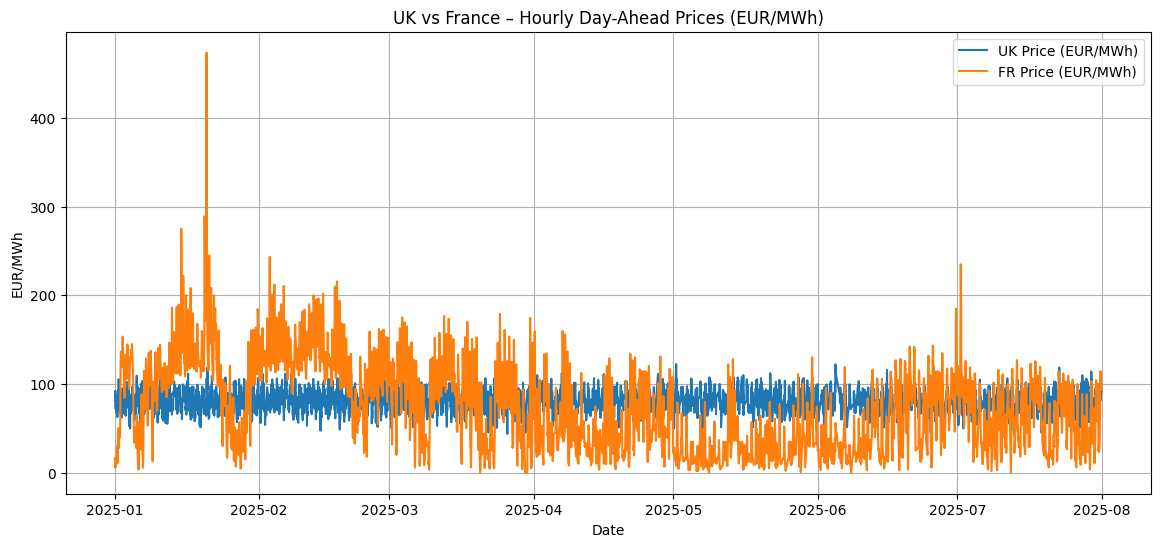

In [127]:
#Plotting the UK and France prices
plt.figure(figsize=(14,6))
plt.plot(df["datetime"], df["UK_price_eur"], label="UK Price (EUR/MWh)")
plt.plot(df["datetime"], df["FR_price"], label="FR Price (EUR/MWh)")
plt.title("UK vs France – Hourly Day-Ahead Prices (EUR/MWh)")
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.show()

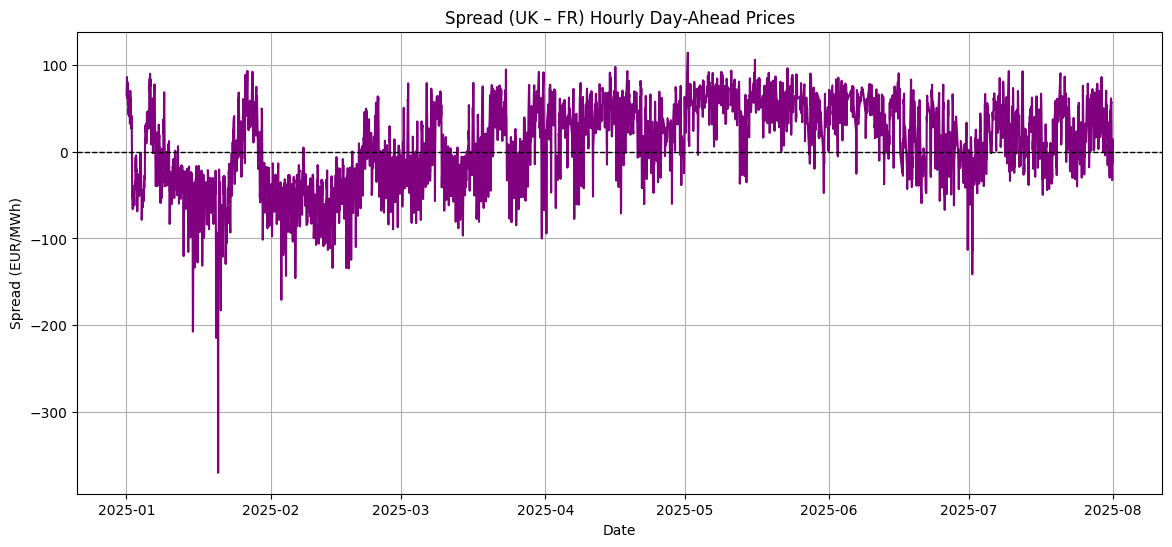

In [128]:
#Generate plot spread - spread eur
plt.figure(figsize=(14,6))
plt.plot(df["datetime"], df["spread_eur"], color="purple")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Spread (UK – FR) Hourly Day-Ahead Prices")
plt.xlabel("Date")
plt.ylabel("Spread (EUR/MWh)")
plt.grid(True)
plt.show()

In [129]:
# Pearson correlation between hourly prices
corr = df["UK_price_eur"].corr(df["FR_price"])

# Compute hourly log-returns
rets = np.log(df[["UK_price_eur", "FR_price"]]).diff().dropna()
rets["spread"] = np.log(df["spread_eur"]).diff().dropna()

# Hourly volatilities of returns
uk_vol_hourly = rets["UK_price_eur"].std()
fr_vol_hourly = rets["FR_price"].std()
spread_vol_hourly = rets["spread"].std()

# Annualise (8760 hours/year)
hours_in_year = 8760
uk_vol_ann = uk_vol_hourly * np.sqrt(hours_in_year)
fr_vol_ann = fr_vol_hourly * np.sqrt(hours_in_year)
spread_vol_ann = spread_vol_hourly * np.sqrt(hours_in_year)

print(f"Correlation (UK vs FR): {corr:.3f}")
print(f"UK Volatility – Hourly: {uk_vol_hourly:.2f} EUR/MWh | Annualised: {uk_vol_ann:.2f}")
print(f"FR Volatility – Hourly: {fr_vol_hourly:.2f} EUR/MWh | Annualised: {fr_vol_ann:.2f}")
print(f"Spread Volatility – Hourly: {spread_vol_hourly:.2f} EUR/MWh | Annualised: {spread_vol_ann:.2f}")

Correlation (UK vs FR): 0.106
UK Volatility – Hourly: 0.17 EUR/MWh | Annualised: 16.26
FR Volatility – Hourly: 0.48 EUR/MWh | Annualised: 45.10
Spread Volatility – Hourly: 0.87 EUR/MWh | Annualised: 81.58


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Summary of results:

### Correlation (UK vs FR): 0.165 

Pearson correlation of hourly prices over your Jan–Jul 2025 sample.

0.165 = very low positive correlation - UK and France prices aren’t strongly linked hour by hour in this dataset — moves in FR don’t reliably predict moves in UK.

Assumptions / Reasons:
	1. Limited interconnector capacity between the UK and France (small cable connectors IFA and IFA2 to FR compared to total system demand)

	2. Currency effects (UK simulated in GBP and converted to EUR which adds noise)

	3. UK prices are simulated and doesnt pick up the shared fundamentals with FR

Implication for spread trading: Low correlation means the spread will be more volatile and less predictable.


### UK Volatility – Hourly: 11.85 EUR/MWh

Standard deviation of hourly UK prices over the period (in EUR/MWh).

	•	Number (11.85):

	- On average, the UK price deviates about ±12 EUR from its mean each hour.

	- This is relatively low compared to FR — UK is “calmer” in your dataset.



### Annualised UK Volatility: 1108.84 EUR/MWh

 Hourly vol × √(hours per year) - Annualising hourly price volatility for power produces big numbers because power prices are not like equity returns — they’re absolute price levels and can swing a lot intraday.

NB// Metric is more about comparing markets on the same scale 



### FR Volatility – Hourly: 51.56 EUR/MWh

France prices swing far more hour-to-hour than UK prices in your dataset.

Reason?: Likely due to higher exposure to volatile supply/demand dynamics, renewables intermittency or price spikes.



### Spread Volatility – Hourly: 50.97 EUR/MWh

	•	What it is: Std dev of (UK_price – FR_price) in EUR.

	- Very close to FR volatility because FR is much more volatile than UK, and correlation is low — FR volatility dominates spread behaviour.

	- A volatile spread means transmission rights can vary hugely in value from hour to hour.


### Key Takeaways

	•	Low correlation (0.165) → UK & FR are weakly linked hourly - spread is not “stable”.

	•	FR volatility dwarfs UK volatility - spread is driven mostly by French market movements.

	•	Spread volatility ~ FR volatility - if you’re valuing a spread option, most risk comes from FR side.

	•	Commercial angle: A trader buying interconnector rights here is betting on FR price spikes or large FR-UK differentials — not on subtle hour-by-hour convergence.


 

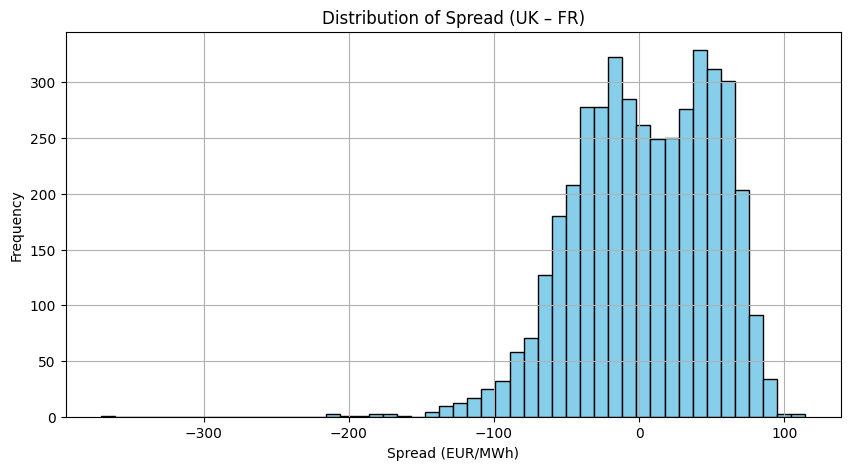

In [130]:
# Distribution of the spread - shows us how often the spread falls within certain ranges
plt.figure(figsize=(10,5))
plt.hist(df["spread_eur"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Spread (UK – FR)")
plt.xlabel("Spread (EUR/MWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

 
## Spread Distribution Insights (UK – FR)

# # Overview:  

The distribution of the UK–FR day-ahead spread (EUR/MWh) shows a strong directional bias with occasional extreme reversals. This behaviour is consistent with real interconnector market dynamics


### 1. Centre & Bias

- **Peak spread**: ~+50 to +80 EUR/MWh  

- **Interpretation**: UK prices are typically higher than FR prices.

- **Commercial implication**: Default profitable flow = France → UK (sell into the premium UK market).


### 2. Spread Range

- **Bulk of spreads**: −50 to +120 EUR/MWh  

- **Extremes**:  

  - Left tail: down to ~−300 EUR/MWh (France price spikes above UK)

  - Right tail: up to ~+200 EUR/MWh (UK price spikes above France)

- **Shape**: Fat-tailed — extreme events occur and cannot be ignored


### 3. Shape & Skew

- **Positive skew**: Most hours are positive spreads (UK > FR)

- **Fat negative tail**: Rare events cause large FR > UK spreads (e.g., nuclear outages, cold snaps, low renewables in FR)

- **Risk implication**: Without two-way flow rights, these rare events can wipe out directional profits



### 4. Market Regimes

1. **Normal regime** (majority): UK commands a consistent price premium.  

2. **Shock regime** (occasional): France experiences price spikes that reverse the spread sharply



### 5. Desk Takeaway (Notes for me)
> "UK premium most of the time — great if you can flow FR → UK.  
> But the left tail will kill gains if you can’t flow the other way.  
> This is a two way optionality story."


### 6. Link to Optionality Value

- The combination of **positive bias** + **fat tails** increases the value of spread options.

- Pricing with **Kirk's Approximation** and **Monte Carlo** will quantify this optionality

- Low correlation (0.165) measured earlier reinforces that spreads are driven by independent shocks, creating trading opportunities.


 